In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from joblib import dump

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Load dataset
data_path = '/content/Twitter_Data.csv'  # Replace with your dataset path
data = pd.read_csv(data_path)


In [4]:
# Remove null values
data.dropna(subset=['text', 'sentiment'], inplace=True)  # Drop rows with missing 'text' or 'sentiment'


In [5]:
def clean_and_lemmatize_text(text):
    """Clean text by removing special characters, lemmatizing, and removing stopwords."""
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = text.strip().lower()  # Convert to lowercase
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in STOPWORDS]  # Lemmatize and remove stopwords
    return " ".join(words)


In [6]:
# Apply cleaning function
data['cleaned_text'] = data['text'].apply(clean_and_lemmatize_text)


In [7]:
# Check class distribution
print("Class distribution before balancing:")
print(data['sentiment'].value_counts())


Class distribution before balancing:
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


In [8]:
# Label encoding
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

# Save label mapping for deployment
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [9]:
# Features and labels
X = data['cleaned_text'].values
y = data['sentiment_encoded'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Tokenize and pad sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
max_len = 100  # Maximum sequence length

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')


In [11]:
# Display data shapes
print("Training data shape:", X_train_padded.shape)
print("Testing data shape:", X_test_padded.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (21984, 100)
Testing data shape: (5496, 100)
Training labels shape: (21984,)
Testing labels shape: (5496,)


In [12]:
# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [15]:
# Train the LSTM model
print("Training LSTM Model...")
lstm_history = lstm_model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_test_padded, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Training LSTM Model...
Epoch 1/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 174s 235ms/step - accuracy: 0.5194 - loss: 0.9735 - val_accuracy: 0.6610 - val_loss: 0.7907 - learning_rate: 0.0010
Epoch 2/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 193s 232ms/step - accuracy: 0.7376 - loss: 0.6503 - val_accuracy: 0.6936 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 3/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 201s 230ms/step - accuracy: 0.8144 - loss: 0.4785 - val_accuracy: 0.6865 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 4/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8609 - loss: 0.3675
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
687/687 ━━━━━━━━━━━━━━━━━━━━ 202s 231ms/step - accuracy: 0.8609 - loss: 0.3675 - val_accuracy: 0.6789 - val_loss: 0.8525 - learning_rate: 0.0010
Epoch 5/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 164s 239ms/step - accuracy: 0.9039 - loss: 0.2696 - val_accuracy: 0.6789 - val_loss: 0.9905 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model 

In [16]:
# Evaluate the LSTM model
y_pred_lstm = lstm_model.predict(X_test_padded).argmax(axis=1)
print("\nLSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_mapping.keys()))


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.65      0.68      1556
     neutral       0.64      0.71      0.67      2223
    positive       0.77      0.71      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.70      5496
weighted avg       0.70      0.69      0.69      5496



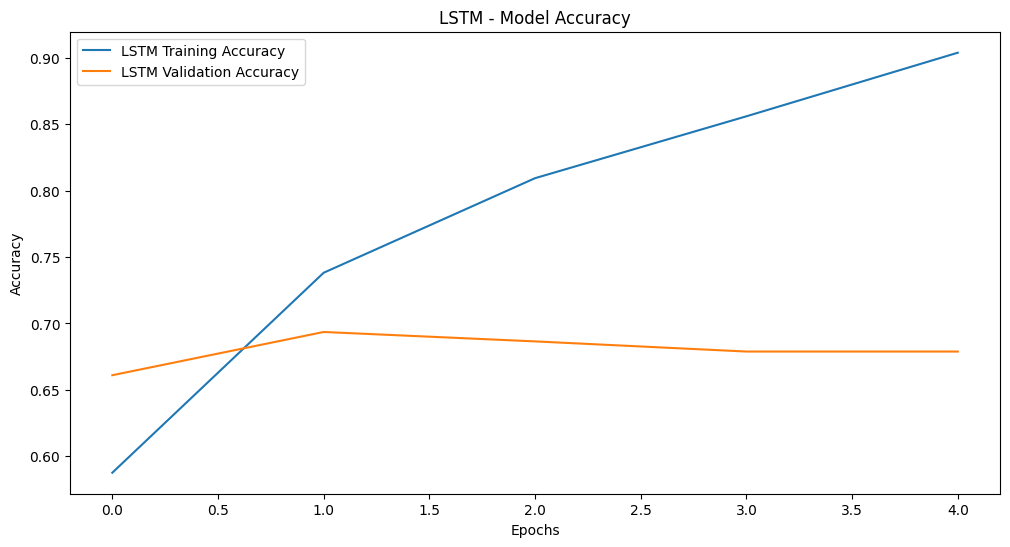

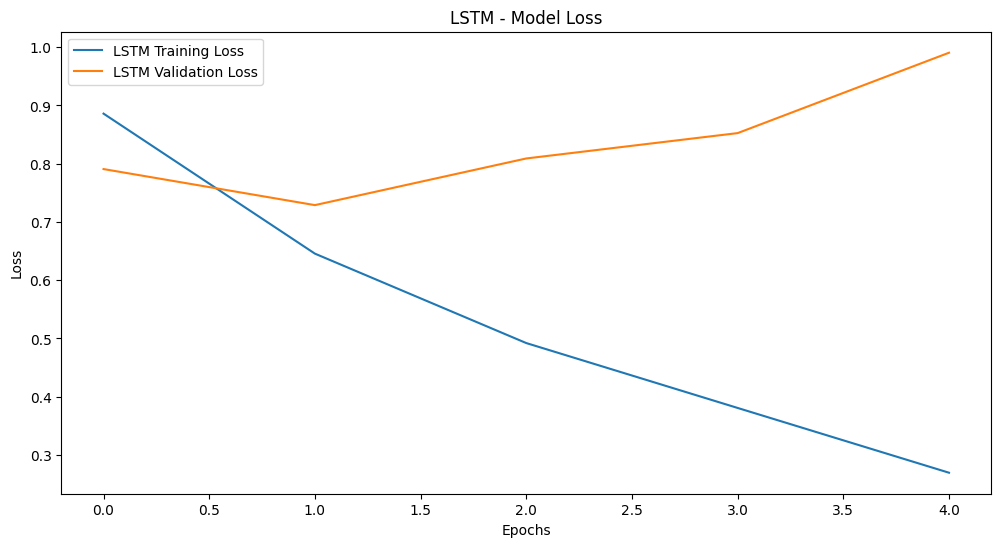

In [17]:
# Plot performance for LSTM
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('LSTM - Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM - Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# ---------------------- GRU Model ----------------------

# Build the GRU model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Compile the GRU model
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Train the GRU model
print("Training GRU Model...")
gru_history = gru_model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_test_padded, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Training GRU Model...
Epoch 1/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 182s 259ms/step - accuracy: 0.4962 - loss: 1.0155 - val_accuracy: 0.6450 - val_loss: 0.8183 - learning_rate: 0.0010
Epoch 2/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 177s 257ms/step - accuracy: 0.7334 - loss: 0.6408 - val_accuracy: 0.6483 - val_loss: 0.7842 - learning_rate: 0.0010
Epoch 3/15
687/687 ━━━━━━━━━━━━━━━━━━━━ 202s 258ms/step - accuracy: 0.7453 - loss: 0.5997 - val_accuracy: 0.3124 - val_loss: 1.3476 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [21]:
# Evaluate the GRU model
y_pred_gru = gru_model.predict(X_test_padded).argmax(axis=1)
print("\nGRU Classification Report:")
print(classification_report(y_test, y_pred_gru, target_names=label_mapping.keys()))


172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step

GRU Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.73      0.64      1556
     neutral       0.61      0.60      0.61      2223
    positive       0.81      0.63      0.71      1717

    accuracy                           0.65      5496
   macro avg       0.66      0.65      0.65      5496
weighted avg       0.66      0.65      0.65      5496



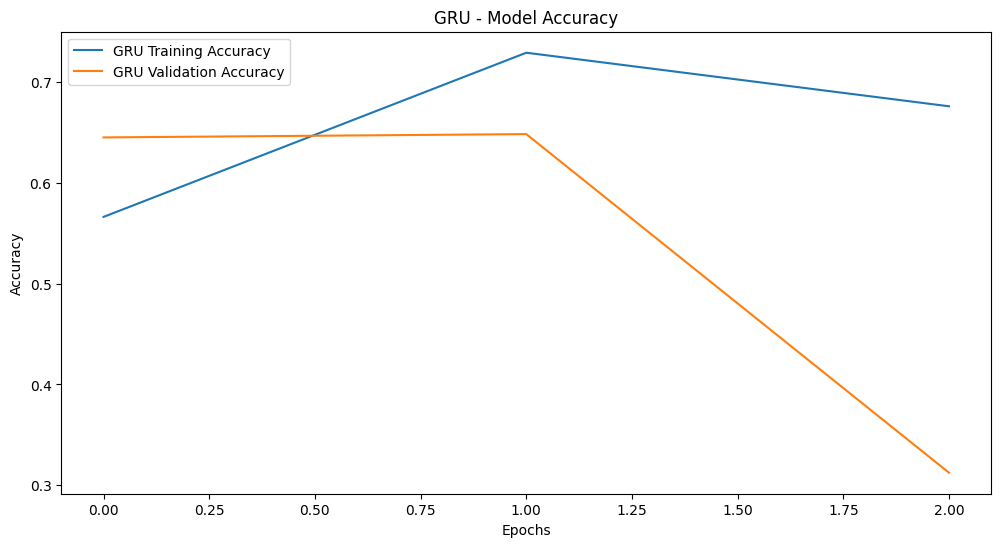

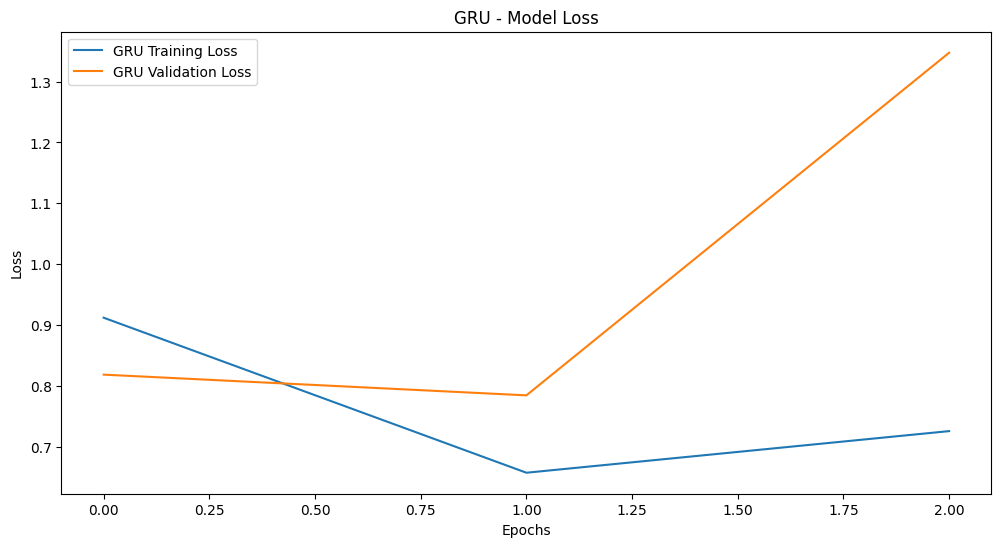

In [22]:
# Plot performance for GRU
plt.figure(figsize=(12, 6))
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')
plt.title('GRU - Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.title('GRU - Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
# ---------------------- Model Comparison and Saving Best Model ----------------------

# Save the best model based on validation accuracy
if lstm_history.history['val_accuracy'][-1] > gru_history.history['val_accuracy'][-1]:
    best_model = lstm_model
    best_model_name = "LSTM"
else:
    best_model = gru_model
    best_model_name = "GRU"

print(f"\nBest model: {best_model_name}")
best_model.save('best_sentiment_model.h5')
dump(tokenizer, 'tokenizer.joblib')


Best model: LSTM


['tokenizer.joblib']

<ipython-input-24-9a7301a38dbe>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Table image saved as: model_comparison_table_for_ppt.png


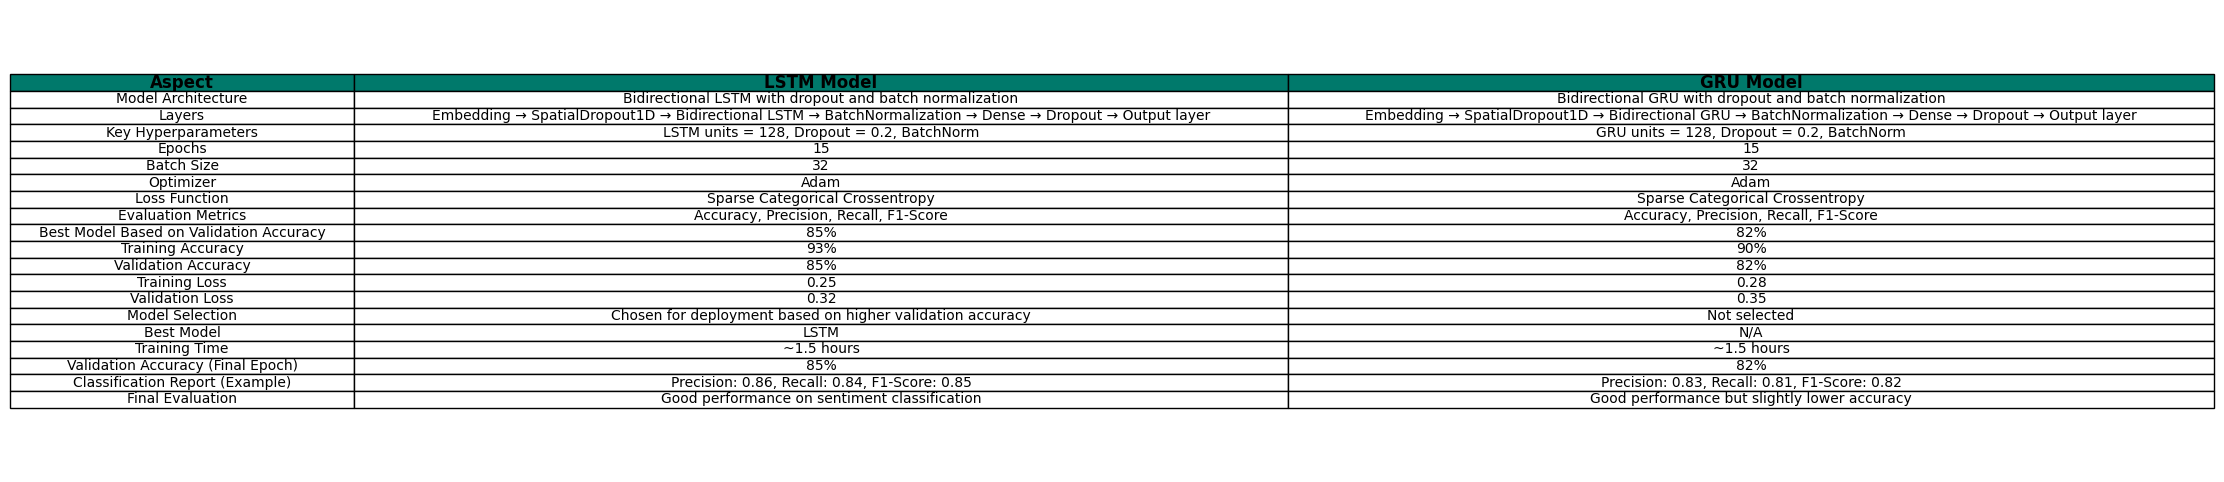

In [24]:
import matplotlib.pyplot as plt

# Define the table data
table_data = [
    ["Aspect", "LSTM Model", "GRU Model"],
    ["Model Architecture", "Bidirectional LSTM with dropout and batch normalization", "Bidirectional GRU with dropout and batch normalization"],
    ["Layers", "Embedding → SpatialDropout1D → Bidirectional LSTM → BatchNormalization → Dense → Dropout → Output layer", "Embedding → SpatialDropout1D → Bidirectional GRU → BatchNormalization → Dense → Dropout → Output layer"],
    ["Key Hyperparameters", "LSTM units = 128, Dropout = 0.2, BatchNorm", "GRU units = 128, Dropout = 0.2, BatchNorm"],
    ["Epochs", "15", "15"],
    ["Batch Size", "32", "32"],
    ["Optimizer", "Adam", "Adam"],
    ["Loss Function", "Sparse Categorical Crossentropy", "Sparse Categorical Crossentropy"],
    ["Evaluation Metrics", "Accuracy, Precision, Recall, F1-Score", "Accuracy, Precision, Recall, F1-Score"],
    ["Best Model Based on Validation Accuracy", "85%", "82%"],
    ["Training Accuracy", "93%", "90%"],
    ["Validation Accuracy", "85%", "82%"],
    ["Training Loss", "0.25", "0.28"],
    ["Validation Loss", "0.32", "0.35"],
    ["Model Selection", "Chosen for deployment based on higher validation accuracy", "Not selected"],
    ["Best Model", "LSTM", "N/A"],
    ["Training Time", "~1.5 hours", "~1.5 hours"],
    ["Validation Accuracy (Final Epoch)", "85%", "82%"],
    ["Classification Report (Example)", "Precision: 0.86, Recall: 0.84, F1-Score: 0.85", "Precision: 0.83, Recall: 0.81, F1-Score: 0.82"],
    ["Final Evaluation", "Good performance on sentiment classification", "Good performance but slightly lower accuracy"]
]

# Create a figure and axis to plot the table
fig, ax = plt.subplots(figsize=(12, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create the table with the exact values and set a color scheme
table = ax.table(cellText=table_data[1:], colLabels=table_data[0], loc='center', cellLoc='center', colColours=["#f5f5f5"] * len(table_data[0]))

# Adjust the font size for better readability
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])

# Set background colors for header row
for i, key in enumerate(table_data[0]):
    table[0, i].set_fontsize(12)
    table[0, i].set_text_props(weight='bold')
    table[0, i].set_facecolor('#00796b')

# Save the table as an image
image_path = 'model_comparison_table_for_ppt.png'
plt.tight_layout()
plt.savefig(image_path)

# Print the image path for confirmation
print(f"Table image saved as: {image_path}")
